# 🎯 06 - Advanced Segmentation

**Week 6 Deliverable**: Advanced Clustering with K-Means & Hierarchical

## Objectives
1. Apply K-Means clustering for customer segmentation
2. Perform Hierarchical clustering analysis
3. Find optimal number of clusters
4. Create and analyze cluster profiles

---

## 1. Setup & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

print('Libraries loaded!')

Libraries loaded!


In [2]:
# Load feature matrix
feature_matrix = pd.read_csv('../data/features/feature_matrix.csv')
clv_data = pd.read_csv('../data/features/clv_predictions.csv')

# Merge CLV
data = feature_matrix.merge(clv_data[['CustomerID', 'CLV_ensemble']], on='CustomerID', how='left')

print(f'Customers: {len(data):,}')

Customers: 4,338


## 2. Prepare Features for Clustering

In [3]:
# Select features for clustering
cluster_features = ['Recency', 'Frequency', 'Monetary']

# Create feature matrix
X = data[cluster_features].fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'Features: {cluster_features}')
print(f'Shape: {X_scaled.shape}')

Features: ['Recency', 'Frequency', 'Monetary']
Shape: (4338, 3)


## 3. Find Optimal Number of Clusters

In [4]:
# Elbow method and Silhouette analysis
k_range = range(2, 11)

inertias = []
silhouettes = []
calinski = []
davies = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))
    calinski.append(calinski_harabasz_score(X_scaled, labels))
    davies.append(davies_bouldin_score(X_scaled, labels))

# Results dataframe
cluster_metrics = pd.DataFrame({
    'k': list(k_range),
    'Inertia': inertias,
    'Silhouette': silhouettes,
    'Calinski-Harabasz': calinski,
    'Davies-Bouldin': davies
})

cluster_metrics

,k,Inertia,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,2,9014.566280,0.895825,1923.724789,0.745018
1,3,5441.323587,0.594223,3016.504324,0.710355
2,4,4096.300211,0.616228,3145.058459,0.754173
3,5,3119.789860,0.616500,3435.456751,0.715971
4,6,2473.793364,0.598289,3691.517722,0.627325
5,7,2023.586627,0.516532,3920.388983,0.633411
6,8,1717.011043,0.485874,4069.902666,0.694751
7,9,1468.787102,0.478438,4253.469579,0.702440
8,10,1281.048051,0.479244,4404.456924,0.677944


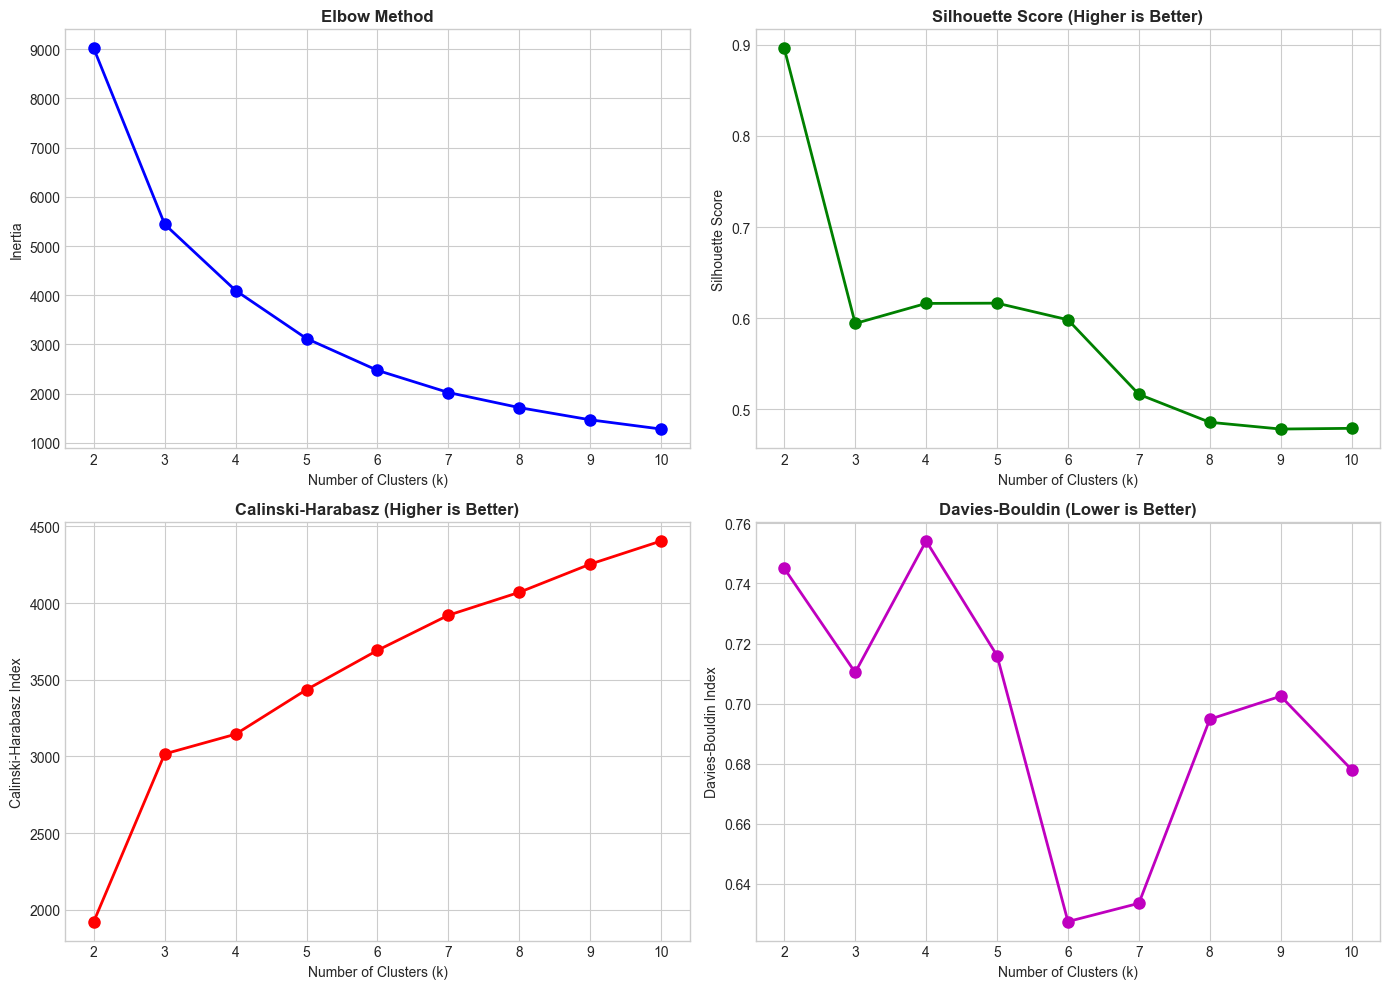


Optimal k (by Silhouette): 2


In [5]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow curve
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method', fontweight='bold')
axes[0, 0].set_xticks(list(k_range))

# Silhouette score
axes[0, 1].plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (Higher is Better)', fontweight='bold')
axes[0, 1].set_xticks(list(k_range))

# Calinski-Harabasz
axes[1, 0].plot(k_range, calinski, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Index')
axes[1, 0].set_title('Calinski-Harabasz (Higher is Better)', fontweight='bold')
axes[1, 0].set_xticks(list(k_range))

# Davies-Bouldin
axes[1, 1].plot(k_range, davies, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Davies-Bouldin Index')
axes[1, 1].set_title('Davies-Bouldin (Lower is Better)', fontweight='bold')
axes[1, 1].set_xticks(list(k_range))

plt.tight_layout()
plt.savefig('../data/processed/cluster_optimization.png', dpi=300)
plt.show()

# Best k based on silhouette
best_k = k_range[np.argmax(silhouettes)]
print(f'\nOptimal k (by Silhouette): {best_k}')

## 4. K-Means Clustering

In [6]:
# Apply K-Means with optimal k (use 5 for business interpretability)
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

print(f'K-Means clustering complete with {n_clusters} clusters')
print(f'Silhouette Score: {silhouette_score(X_scaled, data["KMeans_Cluster"]):.3f}')

# Cluster distribution
data['KMeans_Cluster'].value_counts().sort_index()

K-Means clustering complete with 5 clusters
Silhouette Score: 0.617


KMeans_Cluster
0    3048
1    1063
2       8
3     213
4       6
Name: count, dtype: int64

In [7]:
# Cluster centers (inverse transform)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=cluster_features)
centers_df['Cluster'] = range(n_clusters)

print('=== K-Means Cluster Centers ===')
centers_df

=== K-Means Cluster Centers ===


,Recency,Frequency,Monetary,Cluster
0,43.918635,3.650262,1333.132908,0
1,248.469426,1.553151,478.648242,1
2,6.500000,120.500000,55099.491250,2
3,15.671362,21.286385,12813.941596,3
4,7.666667,42.833333,190808.536667,4


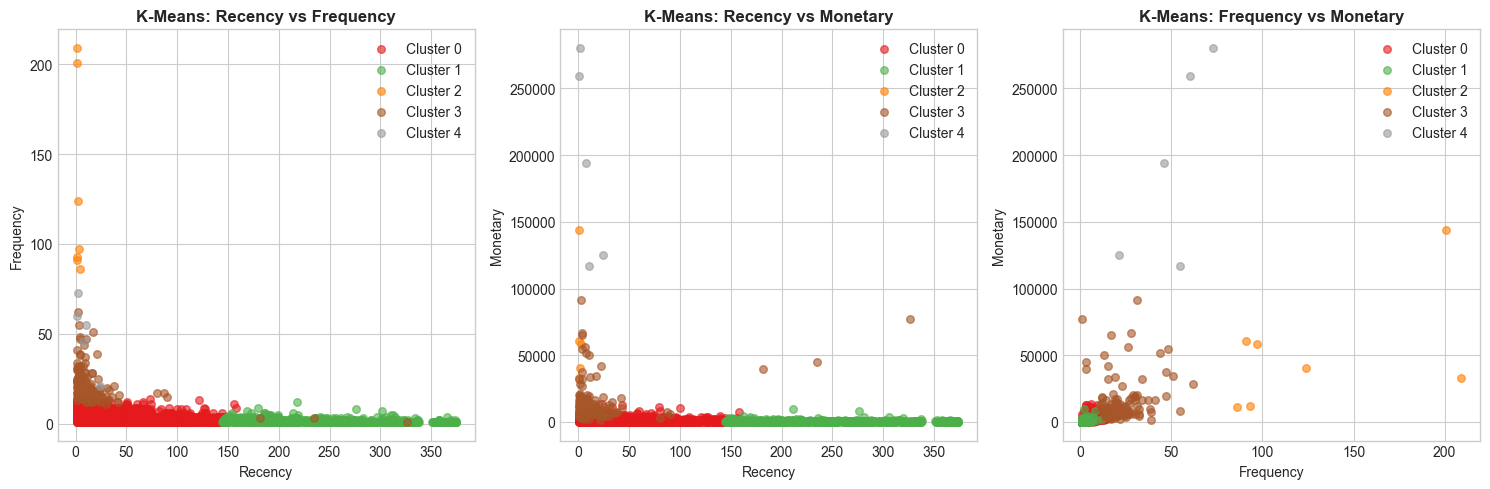

In [8]:
# Cluster visualization (2D projection)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = plt.cm.Set1(np.linspace(0, 1, n_clusters))

# Sample for visualization
sample = data.sample(min(3000, len(data)))

# R vs F
for i in range(n_clusters):
    mask = sample['KMeans_Cluster'] == i
    axes[0].scatter(sample.loc[mask, 'Recency'], sample.loc[mask, 'Frequency'],
                   c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=30)
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Frequency')
axes[0].set_title('K-Means: Recency vs Frequency', fontweight='bold')
axes[0].legend()

# R vs M
for i in range(n_clusters):
    mask = sample['KMeans_Cluster'] == i
    axes[1].scatter(sample.loc[mask, 'Recency'], sample.loc[mask, 'Monetary'],
                   c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=30)
axes[1].set_xlabel('Recency')
axes[1].set_ylabel('Monetary')
axes[1].set_title('K-Means: Recency vs Monetary', fontweight='bold')
axes[1].legend()

# F vs M
for i in range(n_clusters):
    mask = sample['KMeans_Cluster'] == i
    axes[2].scatter(sample.loc[mask, 'Frequency'], sample.loc[mask, 'Monetary'],
                   c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=30)
axes[2].set_xlabel('Frequency')
axes[2].set_ylabel('Monetary')
axes[2].set_title('K-Means: Frequency vs Monetary', fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.savefig('../data/processed/kmeans_clusters.png', dpi=300)
plt.show()

## 5. Hierarchical Clustering

In [9]:
# Use sample for hierarchical clustering (computationally expensive)
sample_size = min(2000, len(X_scaled))
np.random.seed(42)
sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_idx]

# Compute linkage
linkage_matrix = linkage(X_sample, method='ward')

print(f'Hierarchical clustering on {sample_size} samples')

Hierarchical clustering on 2000 samples


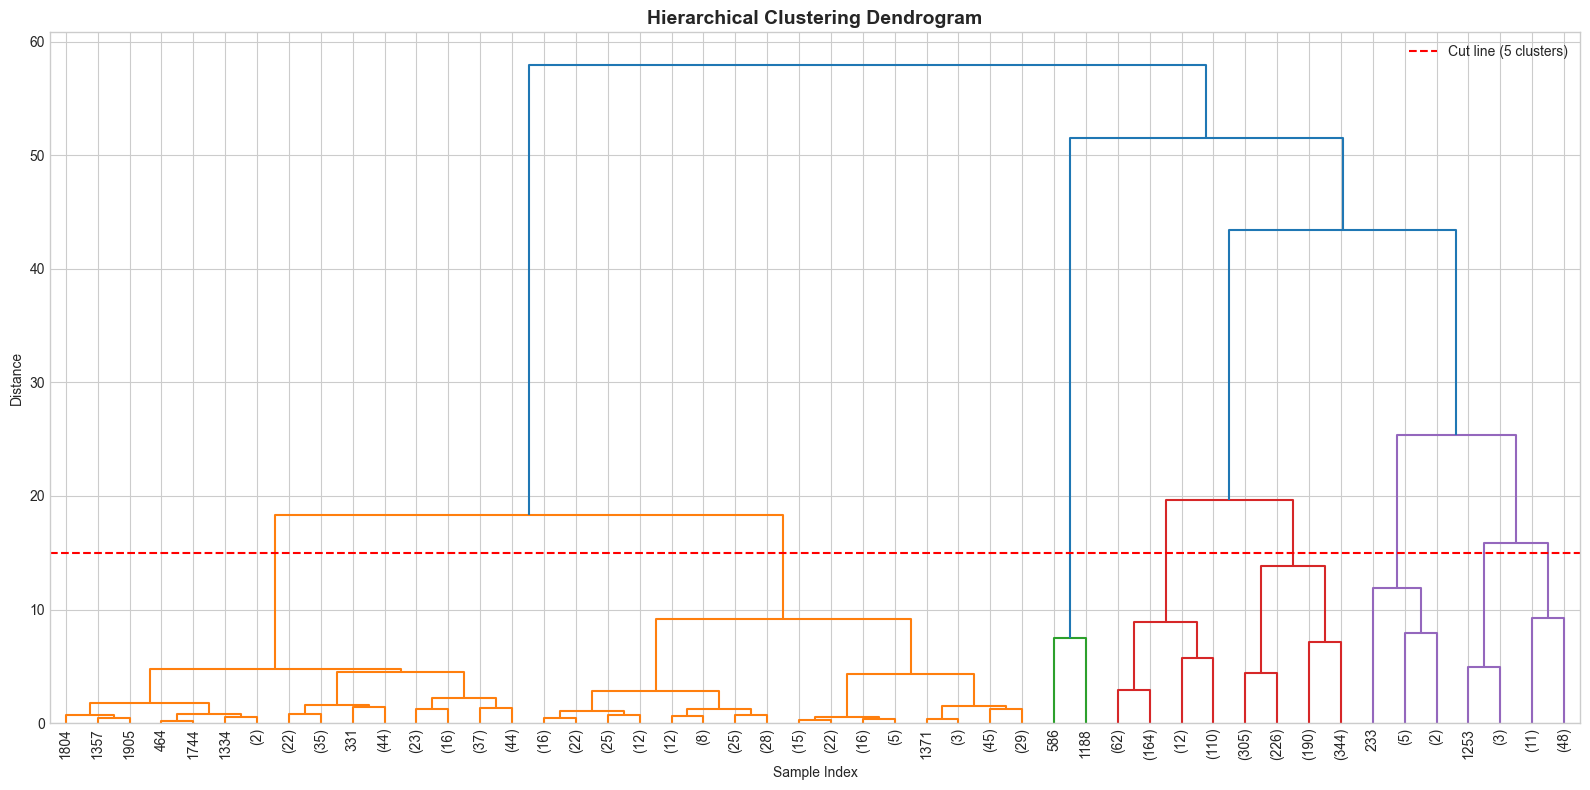

In [10]:
# Dendrogram
plt.figure(figsize=(16, 8))

dendrogram(linkage_matrix, truncate_mode='level', p=5, 
           leaf_rotation=90, leaf_font_size=10)

plt.title('Hierarchical Clustering Dendrogram', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=15, color='r', linestyle='--', label='Cut line (5 clusters)')
plt.legend()
plt.tight_layout()
plt.savefig('../data/processed/dendrogram.png', dpi=300)
plt.show()

In [11]:
# Apply Agglomerative Clustering
hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
data['HC_Cluster'] = hc.fit_predict(X_scaled)

print(f'Hierarchical clustering complete')
print(f'Silhouette Score: {silhouette_score(X_scaled, data["HC_Cluster"]):.3f}')

# Cluster distribution
data['HC_Cluster'].value_counts().sort_index()

Hierarchical clustering complete
Silhouette Score: 0.609


HC_Cluster
0    3042
1       8
2    1134
3     147
4       7
Name: count, dtype: int64

## 6. Cluster Profiles

In [12]:
# K-Means cluster profiles
kmeans_profiles = data.groupby('KMeans_Cluster').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum'],
    'CLV_ensemble': 'mean'
}).round(2)

kmeans_profiles.columns = ['Customers', 'Avg_Recency', 'Avg_Frequency', 
                           'Avg_Monetary', 'Total_Monetary', 'Avg_CLV']

# Add percentage
kmeans_profiles['Pct_Customers'] = (kmeans_profiles['Customers'] / len(data) * 100).round(1)
kmeans_profiles['Pct_Revenue'] = (kmeans_profiles['Total_Monetary'] / kmeans_profiles['Total_Monetary'].sum() * 100).round(1)

kmeans_profiles

,Customers,Avg_Recency,Avg_Frequency,Avg_Monetary,Total_Monetary,Avg_CLV,Pct_Customers,Pct_Revenue
KMeans_Cluster,,,,,,,,
0,3048,43.92,3.65,1333.13,4063389.10,739.27,70.3,45.7
1,1063,248.47,1.55,478.65,508803.08,291.04,24.5,5.7
2,8,6.50,120.50,55099.49,440795.93,28837.85,0.2,5.0
3,213,15.67,21.29,12813.94,2729369.56,7201.76,4.9,30.7
4,6,7.67,42.83,190808.54,1144851.22,84210.40,0.1,12.9


In [13]:
# Assign cluster names based on characteristics
def assign_cluster_name(row):
    if row['Avg_Recency'] < 50 and row['Avg_Frequency'] > 5 and row['Avg_Monetary'] > 2000:
        return 'VIP Champions'
    elif row['Avg_Recency'] < 100 and row['Avg_Frequency'] > 3:
        return 'Loyal Regulars'
    elif row['Avg_Recency'] < 100 and row['Avg_Frequency'] <= 2:
        return 'New Promising'
    elif row['Avg_Recency'] >= 200 and row['Avg_Frequency'] > 3:
        return 'At Risk Valuable'
    elif row['Avg_Recency'] >= 200:
        return 'Dormant'
    else:
        return 'Average'

kmeans_profiles['Cluster_Name'] = kmeans_profiles.apply(assign_cluster_name, axis=1)

# Map back to data
cluster_name_map = dict(zip(kmeans_profiles.index, kmeans_profiles['Cluster_Name']))
data['Cluster_Name'] = data['KMeans_Cluster'].map(cluster_name_map)

kmeans_profiles

,Customers,Avg_Recency,Avg_Frequency,Avg_Monetary,Total_Monetary,Avg_CLV,Pct_Customers,Pct_Revenue,Cluster_Name
KMeans_Cluster,,,,,,,,,
0,3048,43.92,3.65,1333.13,4063389.10,739.27,70.3,45.7,Loyal Regulars
1,1063,248.47,1.55,478.65,508803.08,291.04,24.5,5.7,Dormant
2,8,6.50,120.50,55099.49,440795.93,28837.85,0.2,5.0,VIP Champions
3,213,15.67,21.29,12813.94,2729369.56,7201.76,4.9,30.7,VIP Champions
4,6,7.67,42.83,190808.54,1144851.22,84210.40,0.1,12.9,VIP Champions


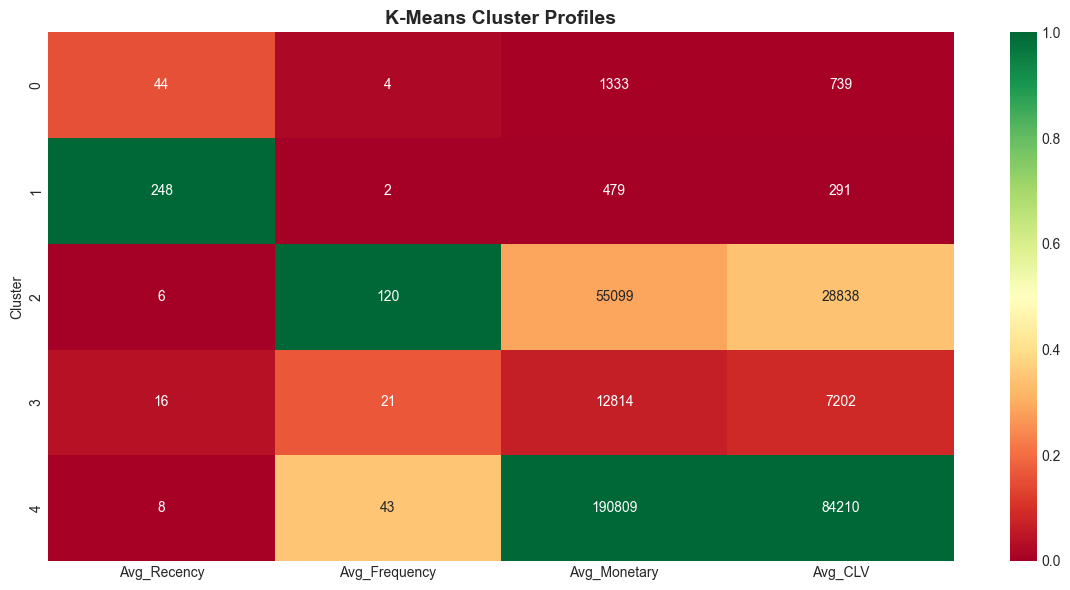

In [14]:
# Cluster profile heatmap
profile_cols = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Avg_CLV']
profile_normalized = kmeans_profiles[profile_cols].copy()

# Normalize for heatmap
for col in profile_cols:
    profile_normalized[col] = (profile_normalized[col] - profile_normalized[col].min()) / \
                              (profile_normalized[col].max() - profile_normalized[col].min())

plt.figure(figsize=(12, 6))
sns.heatmap(profile_normalized, annot=kmeans_profiles[profile_cols].values, 
            fmt='.0f', cmap='RdYlGn', center=0.5)
plt.title('K-Means Cluster Profiles', fontsize=14, fontweight='bold')
plt.ylabel('Cluster')
plt.tight_layout()
plt.savefig('../data/processed/cluster_profiles.png', dpi=300)
plt.show()

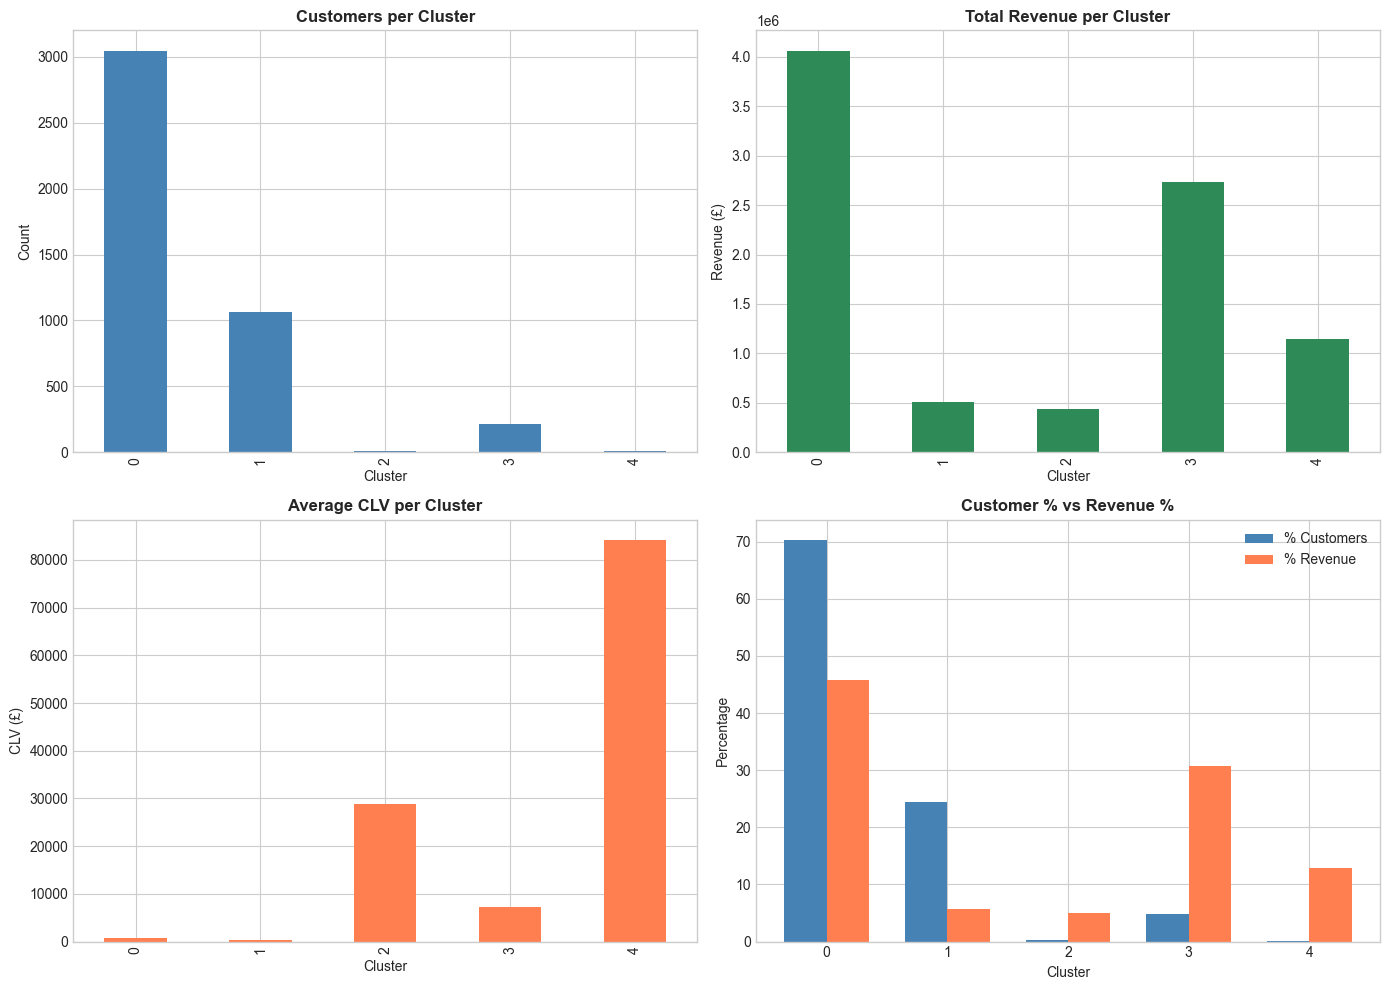

In [15]:
# Cluster comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Customer distribution
kmeans_profiles['Customers'].plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Customers per Cluster', fontweight='bold')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Count')

# Revenue distribution
kmeans_profiles['Total_Monetary'].plot(kind='bar', ax=axes[0, 1], color='seagreen')
axes[0, 1].set_title('Total Revenue per Cluster', fontweight='bold')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Revenue (£)')

# Average CLV
kmeans_profiles['Avg_CLV'].plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Average CLV per Cluster', fontweight='bold')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('CLV (£)')

# Revenue vs Customer contribution
x = np.arange(len(kmeans_profiles))
width = 0.35
axes[1, 1].bar(x - width/2, kmeans_profiles['Pct_Customers'], width, label='% Customers', color='steelblue')
axes[1, 1].bar(x + width/2, kmeans_profiles['Pct_Revenue'], width, label='% Revenue', color='coral')
axes[1, 1].set_title('Customer % vs Revenue %', fontweight='bold')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(kmeans_profiles.index)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../data/processed/cluster_comparison.png', dpi=300)
plt.show()

## 7. Cluster Comparison: K-Means vs Hierarchical

In [16]:
# Compare clustering methods
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(data['KMeans_Cluster'], data['HC_Cluster'])
nmi = normalized_mutual_info_score(data['KMeans_Cluster'], data['HC_Cluster'])

print('=== Clustering Comparison ===')
print(f'Adjusted Rand Index: {ari:.3f}')
print(f'Normalized Mutual Info: {nmi:.3f}')
print(f'\nK-Means Silhouette: {silhouette_score(X_scaled, data["KMeans_Cluster"]):.3f}')
print(f'Hierarchical Silhouette: {silhouette_score(X_scaled, data["HC_Cluster"]):.3f}')

=== Clustering Comparison ===
Adjusted Rand Index: 0.894
Normalized Mutual Info: 0.836

K-Means Silhouette: 0.617
Hierarchical Silhouette: 0.609


In [17]:
# Cross-tabulation
crosstab = pd.crosstab(data['KMeans_Cluster'], data['HC_Cluster'], margins=True)
print('=== K-Means vs Hierarchical Cross-tabulation ===')
crosstab

=== K-Means vs Hierarchical Cross-tabulation ===


HC_Cluster,0,1,2,3,4,All
KMeans_Cluster,,,,,,
0,2977,0,71,0,0,3048
1,0,0,1063,0,0,1063
2,0,1,0,0,7,8
3,65,1,0,147,0,213
4,0,6,0,0,0,6
All,3042,8,1134,147,7,4338


## 8. Key Insights

In [19]:
print('=' * 60)
print('ADVANCED SEGMENTATION - KEY INSIGHTS')
print('=' * 60)

print('\n Clustering Results:')
print(f'   • Optimal clusters: {n_clusters}')
print(f'   • K-Means Silhouette: {silhouette_score(X_scaled, data["KMeans_Cluster"]):.3f}')
print(f'   • Hierarchical Silhouette: {silhouette_score(X_scaled, data["HC_Cluster"]):.3f}')

print('\n Cluster Summary (K-Means):')
for idx, row in kmeans_profiles.iterrows():
    print(f'   Cluster {idx} ({row["Cluster_Name"]}): {row["Customers"]:,} customers, £{row["Total_Monetary"]:,.0f} revenue')

print('\n Key Findings:')
high_value = kmeans_profiles[kmeans_profiles['Pct_Revenue'] > kmeans_profiles['Pct_Customers']]
print(f'   • High-value clusters (revenue > customer %): {len(high_value)}')
print(f'   • Best cluster avg CLV: £{kmeans_profiles["Avg_CLV"].max():,.2f}')
print(f'   • Lowest cluster avg CLV: £{kmeans_profiles["Avg_CLV"].min():,.2f}')

print('\n' + '=' * 60)

ADVANCED SEGMENTATION - KEY INSIGHTS

 Clustering Results:
   • Optimal clusters: 5
   • K-Means Silhouette: 0.617
   • Hierarchical Silhouette: 0.609

 Cluster Summary (K-Means):
   Cluster 0 (Loyal Regulars): 3,048 customers, £4,063,389 revenue
   Cluster 1 (Dormant): 1,063 customers, £508,803 revenue
   Cluster 2 (VIP Champions): 8 customers, £440,796 revenue
   Cluster 3 (VIP Champions): 213 customers, £2,729,370 revenue
   Cluster 4 (VIP Champions): 6 customers, £1,144,851 revenue

 Key Findings:
   • High-value clusters (revenue > customer %): 3
   • Best cluster avg CLV: £84,210.40
   • Lowest cluster avg CLV: £291.04



## 9. Save Results

In [20]:
# Save segmentation results
data[['CustomerID', 'KMeans_Cluster', 'HC_Cluster', 'Cluster_Name']].to_csv(
    '../data/features/advanced_segments.csv', index=False
)

kmeans_profiles.to_csv('../data/features/cluster_profiles.csv')
cluster_metrics.to_csv('../data/features/cluster_metrics.csv', index=False)

print('Segmentation results saved!')
print('  - advanced_segments.csv')
print('  - cluster_profiles.csv')
print('  - cluster_metrics.csv')

Segmentation results saved!
  - advanced_segments.csv
  - cluster_profiles.csv
  - cluster_metrics.csv


## Next Steps

Continue to **Notebook 07 - Business Recommendations** to:
- Generate actionable recommendations
- Calculate ROI projections
- Create implementation roadmap